# Calibration frames

#### Prerequisite:
- `basic_stat.ipynb`
- Knowledge about CCD, bias, dark, and flat frames.

#### We will learn:
- What do bias, dark, and flat frames look like
- How to deal with outliers; sigma-clipping.
- How to combine individual calibration frames to make "master" calibration frames.
- Further familiarize with operations on numpy arrays and data I/O.

#### Reference
- [Here](https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/01-01-astronomical-CCD-image-components.html) is a **great** tutorial on CCD data reduction. Please check out!!
- Howell, S., Handbook of CCD Astronomy, Second Ed, Cambridge University Press 2006

``I suppose Jenny already introduced bias, dark, flat frames. Here I will demonstrate what real bias frames look like, and why we need to stack them.``

In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt

# We can beautify our plots by changing the matpltlib setting a little
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.linewidth'] = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Bias frames

As introduced in class, a voltage is applied to every pixel to make sure the pixel value is always positive. This voltage introduces a "bias" to pixel values. However, this bias is slightly different for each pixel and might change over time. Therefore, we need to take some zero-time exposures (such that dark current and real photons don't contribute to the pixel values) to characterize the bias. 

Below we load bias frames taken using the camera of IFU-M on the 6.5 m [Magellan telescope](https://en.wikipedia.org/wiki/Magellan_Telescopes) in Chile. 

In [4]:
import os
from astropy.io import fits
from utils import show_image

path = '/Users/jiaxuanl/Dropbox (Princeton)/Data/IFU-M/Mar22/'
os.chdir(path)

It's our first time reading a FITS file. FITS (Flexible Image Transport System) format is widely used in astronomy for images and tables. The following code will read the file `b0854c1.fits`, which is a list containing only one HDU (Header Data Unit). 

In [5]:
fits.open('./b0854c1.fits')

```{margin}
`.info()` is quite helpful for understanding the structure of a FITS file. 
```

In [6]:
fits.open('./b0854c1.fits').info()

Filename: ./b0854c1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   (2176, 1156)   int16 (rescales to uint16)   


Now we know that this file has one HDU, which is an image containing 2176 * 1156 pixels. The data type in `int16`. Let's read the data array.

In [7]:
hdu = fits.open('./b0854c1.fits')[0]
img = hdu.data
img

array([[810, 816, 817, ..., 816, 809, 811],
       [816, 820, 823, ..., 815, 819, 822],
       [823, 806, 825, ..., 818, 810, 817],
       ...,
       [816, 820, 817, ..., 816, 817, 812],
       [820, 821, 813, ..., 821, 825, 816],
       [812, 818, 820, ..., 812, 814, 820]], dtype=uint16)

In [13]:
np.median(img), np.std(img)

(817.0, 10.511967775042244)

The pixel values in this bias frame are centered around ~817, and have a dispersion of ~11. This dispersion is largely contributed by the read-out noise, a noise that added to each pixel when reading the charge out. Read-out noise may be viewed as a "toll" that must be paid for reading the stored charge.

In [14]:
np.sum(img < 0)

0

Thanks to the bias voltage, none of the pixels are negative. We can further visualize the bias frame as follows.

```{margin}
We provide a function `show_image` to help visualize astronomical images that typically have a large dynamical range. Please feel free to use it.
```

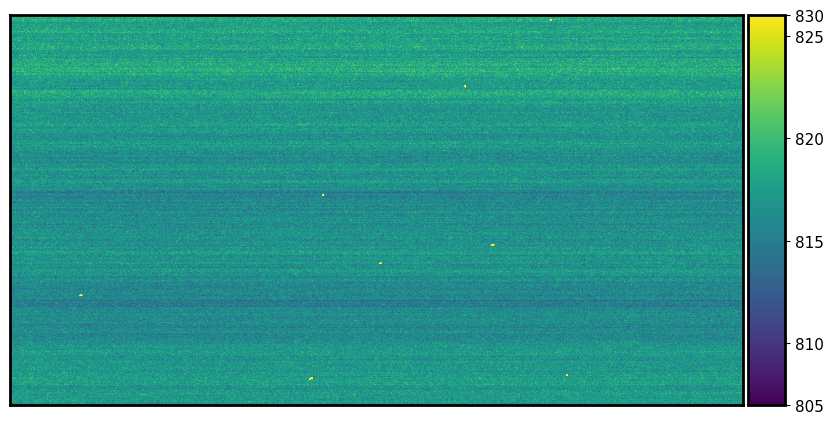

In [65]:
show_image(img, show_colorbar=True);

The bias frame shows some spatial patterns: some rows have a lower bias value than others. We also see some distinct "bright" pixels. They could be either bad pixels, or caused by Cosmic Rays (CR). As a consequence, when we plot the histogram of pixel values, we will see some outliers from the bulk of pixels.

```{margin}
This figure highlights the difference between linear (left) and logarithmic (right) scales when plotting histogram. The number of outliers is too small to be visible in the left histogram with a linear scale in the y-axis. Logarithmic scale comes to save us. When you encounter a dataset that spans a huge dynamical range, maybe you should consider using `log` scale. 
```

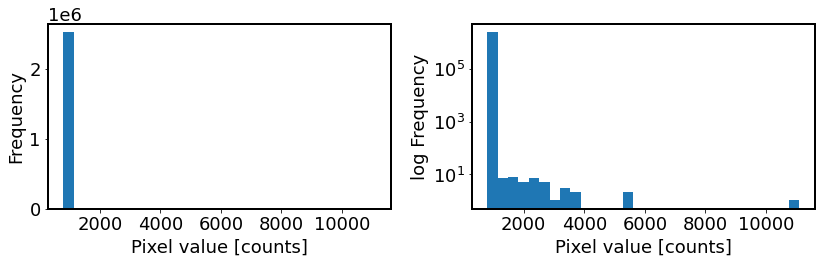

In [27]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(img.flatten(), bins=30)
ax1.set_xlabel('Pixel value [counts]')
ax1.set_ylabel('Frequency')
ax2.hist(img.flatten(), bins=30)
ax2.set_yscale('log')
ax2.set_xlabel('Pixel value [counts]')
ax2.set_ylabel('log Frequency')

plt.tight_layout()

During the Magellan observation, we took ~150 bias frames. So let's load another bias frame. What do you expect? Will it be very different from the one above?

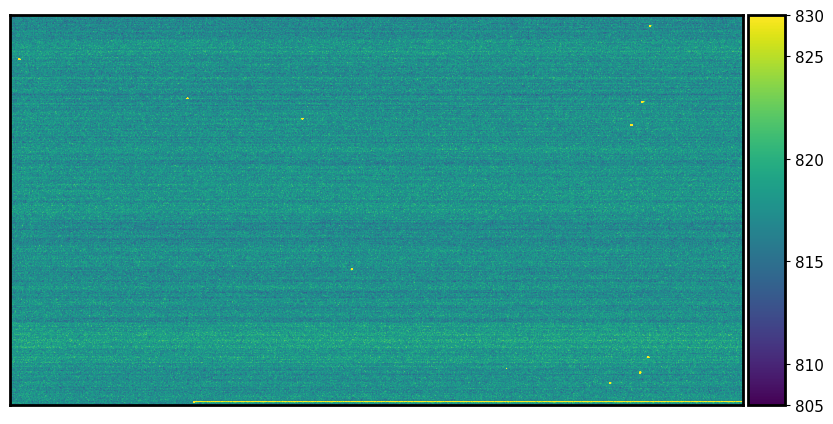

In [66]:
show_image(fits.open('./b0855c1.fits')[0].data);

Hmmm, the bright spots changed their positions in the image. So it does seem like they are caused by cosmic rays. 

### Combine bias frames
We have already learned from `basic_stat.ipynb` that combining images will reduce the noise leve. Belowe we try to combine 50 bias frames. 

```{margin}
Here I use ["Nested List Comprehensions"](https://docs.python.org/3/tutorial/datastructures.html) to construct a list. This is equivalent to the following snippet, but is much shorter.

```{python}
biases = []
for ind in range(854, 904):
    biases.append(fits.open(f'./b0{ind}c1.fits')[0].data)

```
```

In [29]:
biases = [fits.open(f'./b0{ind}c1.fits')[0].data for ind in range(854, 904)]
biases = np.array(biases)

In [31]:
biases.shape

(50, 1156, 2176)

In [32]:
# We have introduced how to calculate the mean and median image using the `axis` argument.
# Check `basic_stat.ipynb`
med_bias = np.median(biases, axis=0)
mean_bias = np.mean(biases, axis=0)

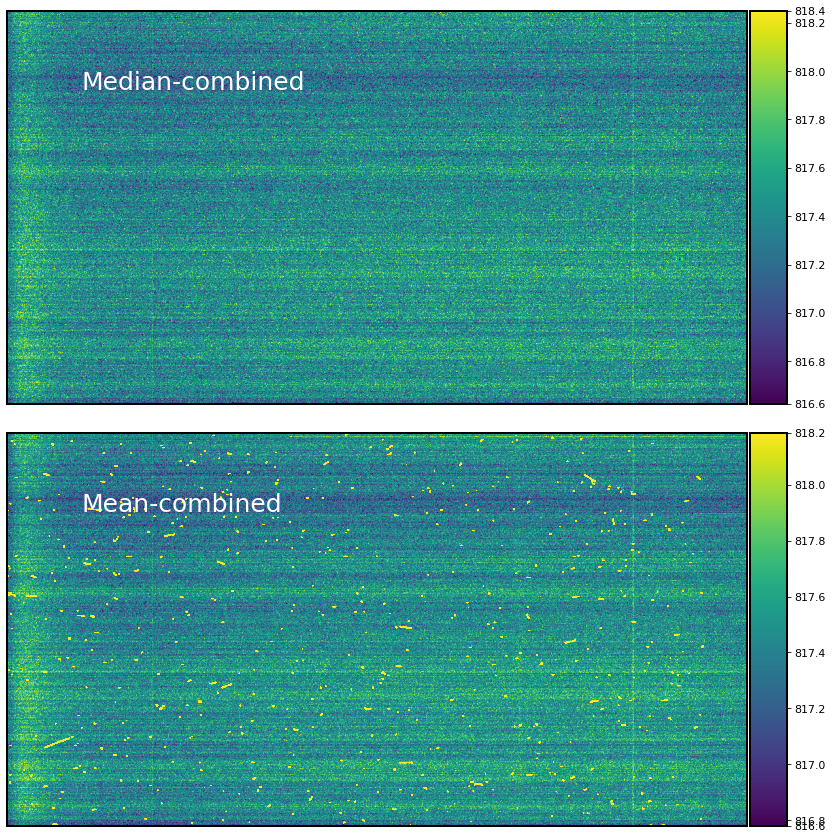

In [90]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 12))

ax1 = show_image(med_bias, ax=ax1, fig=fig,)
ax1.text(0.1, 0.8, 'Median-combined', fontsize=25, color='w', 
         ha='left', transform=ax1.transAxes)

ax2 = show_image(mean_bias, ax=ax2, fig=fig,)
ax2.text(0.1, 0.8, 'Mean-combined', fontsize=25, color='w', 
         ha='left', transform=ax2.transAxes)

plt.tight_layout()

Wow! The cosmic rays are everywhere in the mean-combined image! The vast difference between the median-combined and mean-combined images highlights that the mean is far less immune to outliers (i.e., cosmic rays) than the median. Because of this, we often use median to combine images.

The histogram below shows again that combining individual bias frames will help reduce the read-out noise, thus boost the SNR. 

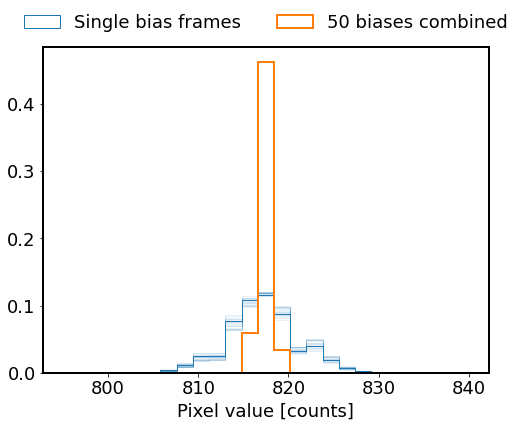

In [132]:
plt.hist(biases[0].flatten(), histtype='step', density=True, 
         range=(795, 840), bins=25, lw=1, label='Single bias frames')
for i in range(1, 21):
    plt.hist(biases[i].flatten(), histtype='step', density=True, 
         range=(795, 840), bins=25, alpha=0.1, color='C0')

plt.hist(med_bias.flatten(), histtype='step', density=True, 
         range=(795, 840), bins=25, lw=2, label='50 biases combined')

plt.xlabel('Pixel value [counts]')

plt.legend(loc='upper center', ncols=2, frameon=False, bbox_to_anchor=(0.5, 1.15));

In [126]:
biases = np.array([fits.open(f'./b0{ind}c3.fits')[0].data.astype(float) for ind in range(854, 954)])

In [127]:
med_bias = np.median(biases, axis=0)

In [288]:
stds = np.std(biases, axis=0)

(array([3.00000e+00, 1.90000e+01, 9.80000e+01, 4.76000e+02, 1.67600e+03,
        5.34000e+03, 1.42750e+04, 3.27760e+04, 6.39940e+04, 1.10213e+05,
        1.71044e+05, 2.30816e+05, 2.84336e+05, 3.09153e+05, 3.09408e+05,
        2.79246e+05, 2.30395e+05, 1.72589e+05, 1.20858e+05, 7.73560e+04,
        4.57320e+04, 2.49560e+04, 1.26960e+04, 5.88700e+03, 2.67200e+03,
        1.12400e+03, 4.65000e+02, 2.36000e+02, 1.75000e+02, 2.19000e+02]),
 array([2.        , 2.13333333, 2.26666667, 2.4       , 2.53333333,
        2.66666667, 2.8       , 2.93333333, 3.06666667, 3.2       ,
        3.33333333, 3.46666667, 3.6       , 3.73333333, 3.86666667,
        4.        , 4.13333333, 4.26666667, 4.4       , 4.53333333,
        4.66666667, 4.8       , 4.93333333, 5.06666667, 5.2       ,
        5.33333333, 5.46666667, 5.6       , 5.73333333, 5.86666667,
        6.        ]),
 <BarContainer object of 30 artists>)

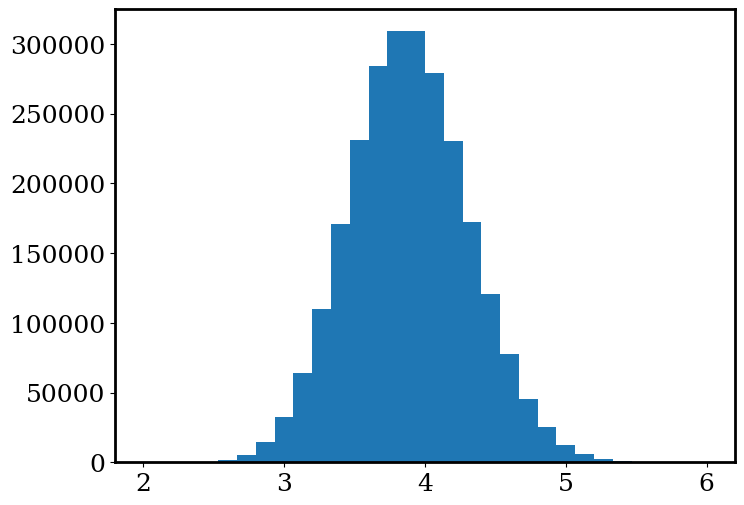

In [294]:
plt.hist(stds.flatten(), range=(2, 6), bins=30)

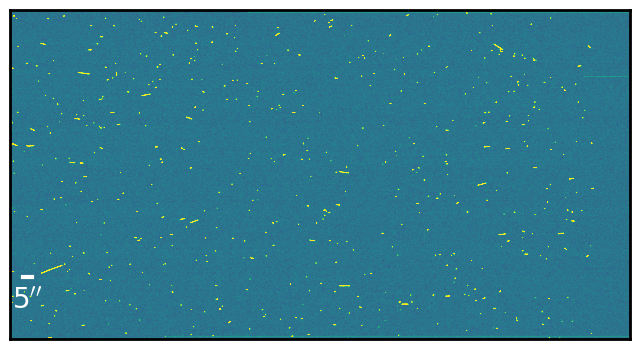

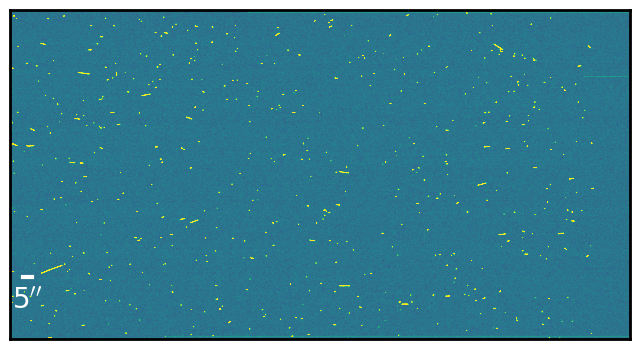

In [290]:
display_single(stds, )

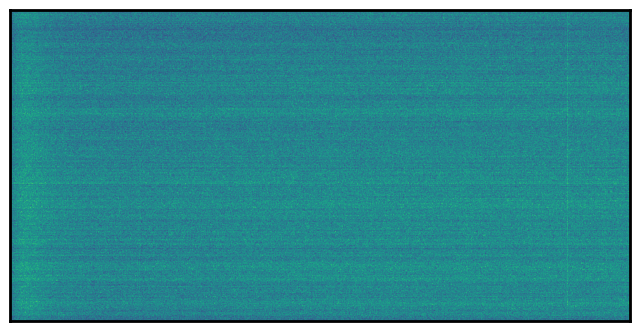

In [284]:
display_single(med_bias, scale_bar=False);

In [323]:
path = '/Users/jiaxuanl/Dropbox (Princeton)/Data/IFU-M/'
os.chdir(path)

sci = fits.open(f'./Mar22/b1190c1.fits')[0].data
twi = fits.open(f'./Mar22/b1204c1.fits')[0].data
bias = fits.open(f'./Mar22/b0855c1.fits')[0].data
bias = bias - np.median(bias[:, 2048:], axis=1)[:,None] # overscan
bias = bias[:1028, :2048]
# bias = bias - np.mean(bias[1028:1155, 2048:]) # overscan
# bias = bias[:1028, :2048]
# master_bias = fits.open('./bbiasc1.fits')[0].data

In [318]:
# display_single((bias - np.median(bias[1028:, :], axis=0)[None, :]));

In [ ]:
biases = np.array([fits.open(f'./b0{ind}c3.fits')[0].data.astype(float) for ind in range(854, 954)])

In [332]:
biases = []
for ind in range(854, 884):
    bias = fits.open(f'./Mar22/b0{ind}c3.fits')[0].data
    bias = bias - np.median(bias[:, 2048:], axis=1)[:,None] # overscan
#     bias = bias - np.median(bias[1028:, :], axis=0)[None,:] # overscan
    bias = bias[:1028, :2048]
    biases.append(bias)
biases = np.array(biases).astype(np.float32)

In [333]:
biases.shape

(30, 1028, 2048)

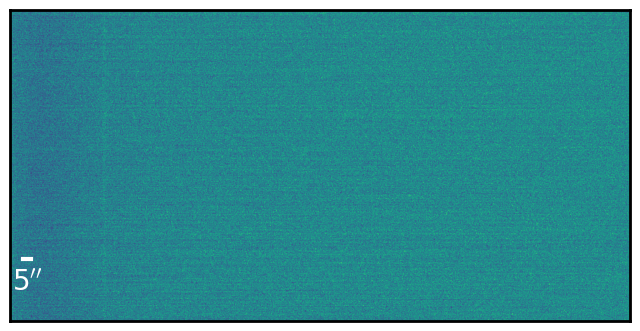

In [334]:
display_single(np.median(biases, axis=0));

In [335]:
from astropy.stats import sigma_clip

In [342]:
filtered_data = sigma_clip(biases, sigma=3, maxiters=5,
                           cenfunc='median', stdfunc='std', 
                           axis=0,
                           masked=False)

In [348]:
med_bias = np.nanmean(filtered_data, axis=0)

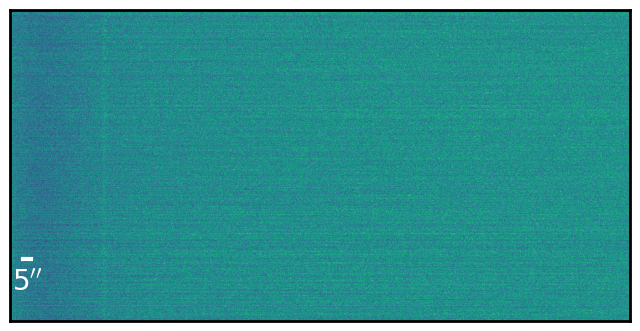

In [351]:
display_single(med_bias);

In [340]:
filtered_data.shape

(30, 1028, 2048)

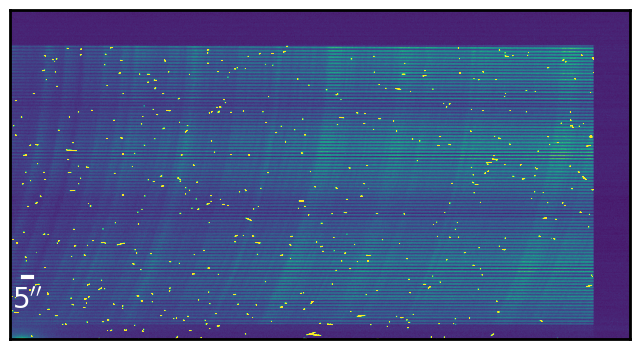

In [303]:
display_single(sci);

In [280]:
med_bias = np.median((biases - np.mean(biases[:, 1028:1155, 2048:], axis=(1, 2))[:, None, None]), axis=0)

In [281]:
med_bias = med_bias[:1028, :2048]

In [207]:
bias.shape

(1156, 2176)

(800.0, 900.0)

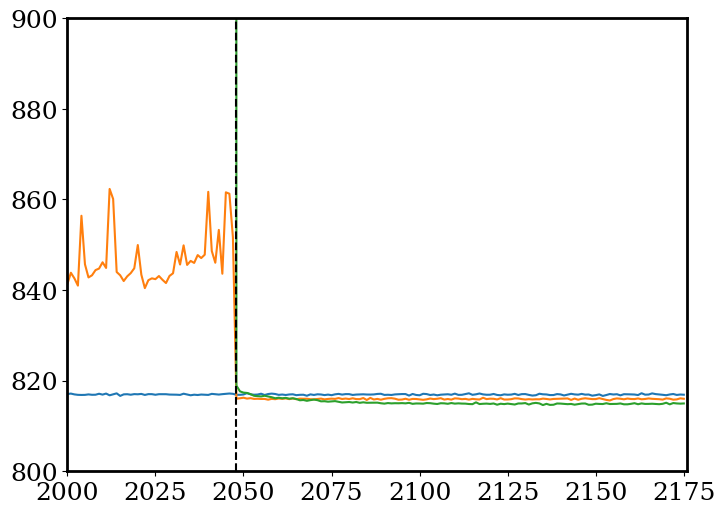

In [212]:
plt.plot(np.mean(bias[:2047, :], axis=0))
plt.plot(np.mean(sci[:2047, :], axis=0))
plt.plot(np.mean(twi[:2047, :], axis=0))
plt.xlim(2000, 2176)

plt.axvline(2048, color='k', ls='--')
plt.ylim(800, 900)

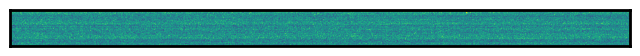

In [236]:
display_single(bias[1028:1155, :], scale_bar=False);

In [225]:
np.std(bias[:, 500:600])

3.964860680805017

In [226]:
2.7 / 0.68

3.9705882352941178

In [239]:
bias.shape

(1156, 2176)

(array([      0.,       0.,       0.,       0., 1363518.,  741826.,
              0.,       0.,       0.,       0.]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 [<matplotlib.patches.Polygon at 0x7fd658b15580>])

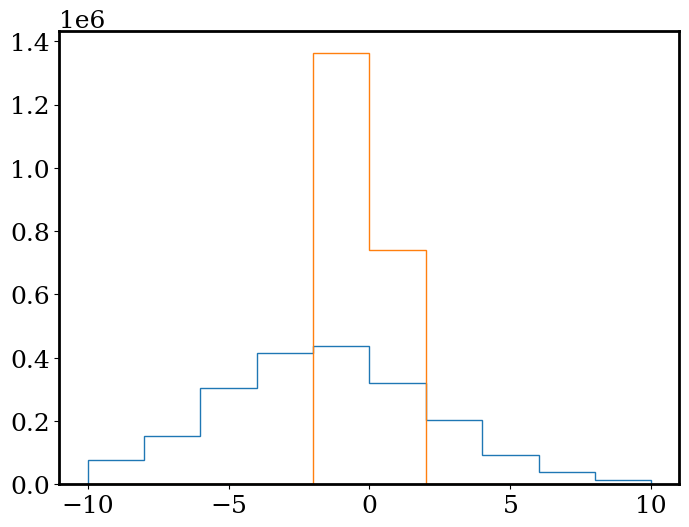

In [253]:
plt.hist(bias.flatten(), range=(-10, 10), histtype='step')
plt.hist(master_bias.flatten(), range=(-10, 10), histtype='step')

In [255]:
np.std(bias - master_bias)

11.22369262482501

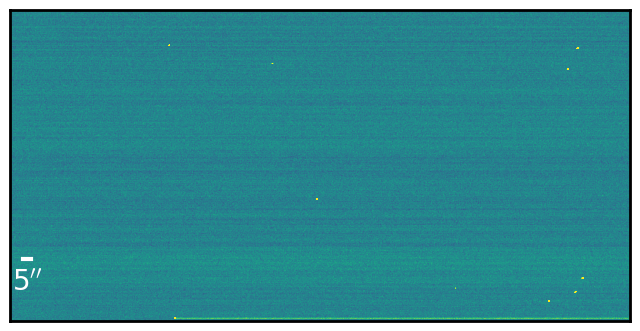

In [261]:
display_single(bias);

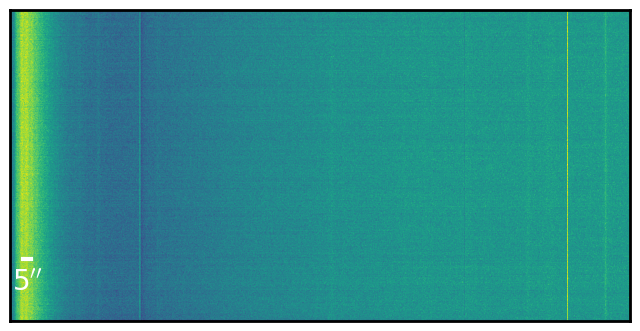

In [244]:
display_single(master_bias);

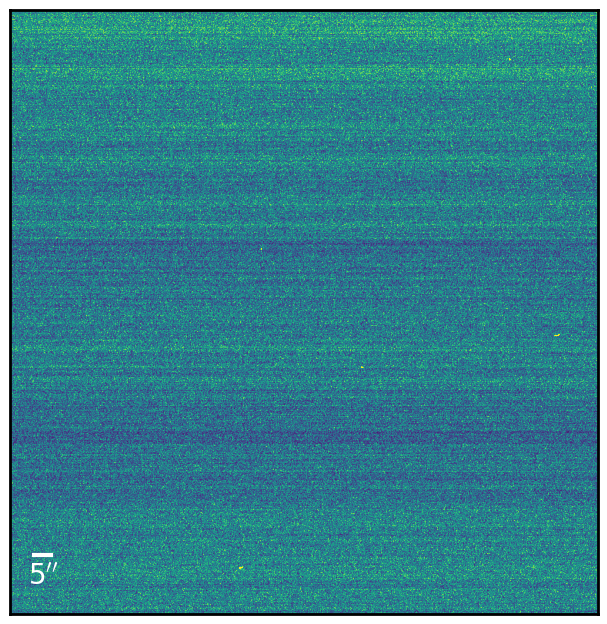

In [242]:
display_single(bias[:, 500:1500]); # [:1028, :2048]

In [ ]:
bias

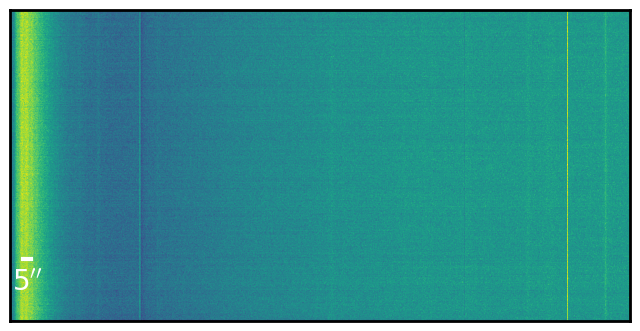

In [155]:
display_single(fits.open('./bbiasc1.fits')[0].data);

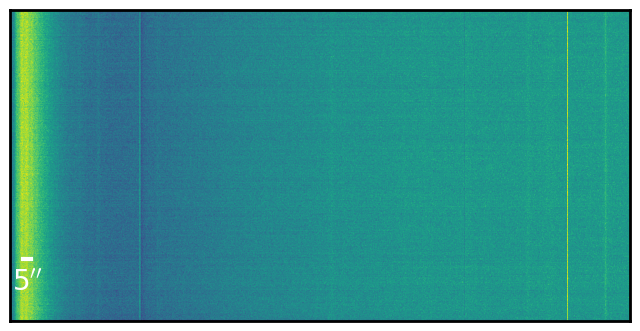

In [160]:
display_single(fits.open('./IFUM_IRAF_0/ifum/TEST_Data/Biases/bbiasc1.fits')[0].data);